## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras
import tensorflow as tf
# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.65) #占用65%顯存
sess =  tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            # Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            # Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
           # Dense是全連接層，該層的輸出維度n_units，激活函數='softmax'
    
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
# 超參數設定
LEARNING_RATE = [0.01] # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = [0.9, 0.8, 0.7] # 動量
nesteror=[True,False] # Nesterov動量

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for m in MOMENTUM:
    for n in nesteror:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with momentum={}, nesteror={}".format(m,n))
        model = build_mlp(input_shape=x_train.shape[1:])
        # 用 Keras 內建方法檢視模型各層參數量
        model.summary()
        # 優化器參數設定
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=n, momentum=m)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        '''
        參數說明:
        lr：float> = 0.學習率。
        momentum：float> =0。參數，用於加速SGD在相關方向上前進，並抑制震盪。
        decay：float> =0。每次參數更新後學習率衰減值。
        nesterov：布林值。是否使用Nesterov動量。
        '''
    
        model.fit(x_train, y_train, # 訓練資料
                  epochs=EPOCHS,   # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
                  batch_size=BATCH_SIZE,  # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
                  validation_data=(x_test, y_test),  # 驗證資料
                  shuffle=True) # 每次epochs後，將訓練集打亂順序
    
        # Collect results
        # history.history:記錄了損失函數和其他指標的數值隨epoch變化的情況，如果有驗證集的話，也包含了驗證集的這些指標變化情況
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        exp_name_tag = 'EXP_momentum={}_nesteror={}'.format(m,n)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-accuracy': train_acc,
                                 'valid-accuracy': valid_acc}


Experiment with momentum=0.9, nesteror=True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/5000

Epoch 46/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.6448 - accuracy: 0.7672 - val_loss: 1.5671 - val_accuracy: 0.5409
Epoch 47/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.6291 - accuracy: 0.7739 - val_loss: 1.5847 - val_accuracy: 0.5341
Epoch 48/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.6207 - accuracy: 0.7781 - val_loss: 1.6198 - val_accuracy: 0.5442
Epoch 49/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.6036 - accuracy: 0.7837 - val_loss: 1.6202 - val_accuracy: 0.5334
Epoch 50/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.5794 - accuracy: 0.7926 - val_loss: 1.6999 - val_accuracy: 0.5314
Experiment with momentum=0.8, nesteror=True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_

Epoch 41/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.8408 - accuracy: 0.7035 - val_loss: 1.3821 - val_accuracy: 0.5393
Epoch 42/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.8235 - accuracy: 0.7069 - val_loss: 1.4391 - val_accuracy: 0.5252
Epoch 43/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.8085 - accuracy: 0.7150 - val_loss: 1.3922 - val_accuracy: 0.5446
Epoch 44/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.7865 - accuracy: 0.7250 - val_loss: 1.4367 - val_accuracy: 0.5348
Epoch 45/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.7798 - accuracy: 0.7270 - val_loss: 1.4113 - val_accuracy: 0.5416
Epoch 46/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.7667 - accuracy: 0.7293 - val_loss: 1.5608 - val_accuracy: 0.5182
Epoch 47/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.7648 - accuracy: 0.7325 - 

Epoch 36/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.0065 - accuracy: 0.6447 - val_loss: 1.6492 - val_accuracy: 0.4687
Epoch 37/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.0030 - accuracy: 0.6468 - val_loss: 1.3314 - val_accuracy: 0.5350
Epoch 38/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.9811 - accuracy: 0.6554 - val_loss: 1.3823 - val_accuracy: 0.5314
Epoch 39/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.9722 - accuracy: 0.6571 - val_loss: 1.4273 - val_accuracy: 0.5139
Epoch 40/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.9521 - accuracy: 0.6684 - val_loss: 1.4691 - val_accuracy: 0.5035
Epoch 41/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.9484 - accuracy: 0.6677 - val_loss: 1.3265 - val_accuracy: 0.5421
Epoch 42/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.9287 - accuracy: 0.6738 - val_

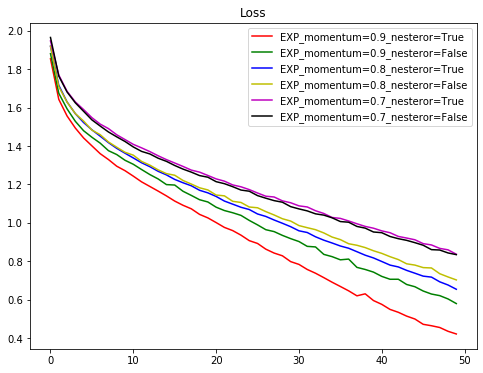

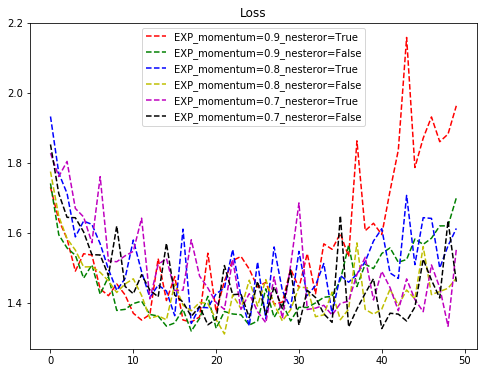

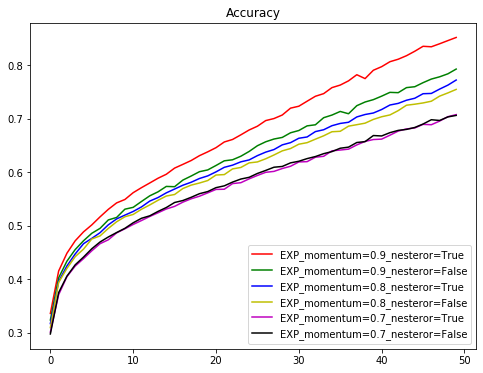

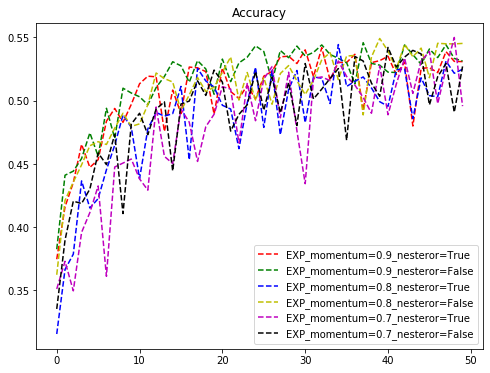

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()